In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.mlab as mlab

import types as types

import sys as sys
import os as os
sys.path.append('scripts27/')
sys.path.append('scripts27/gauss_mix')

import pyglet as pgl
import numpy as np

from main import Main
import gmix_model as gmix
import gmix_sample_mixture as smpl
import graph_NPZ as graph_highD

Loading chipmunk for Darwin (64bit) [/Users/azane/GitRepo/spider/venv/lib/python2.7/site-packages/pymunk/libchipmunk.dylib]


In [2]:
main = Main()
pgl.app.run()

In [3]:
s_x, s_t = gmix.get_xt_from_npz('data/spi_data.npz', True)

rand_x = np.random.random_sample(size=(1000, main.space.expHQ._xDim))
rand_x *= np.sum((main.space.expHQ._xRange*np.array([[[-1,1]]])), axis=2)
rand_x += np.expand_dims(main.space.expHQ._xRange[:,0],0)

_, pv_v, pv_c, pv_t, pv_s, pv_tests = main.space.expHQ.graph_space(s_x)
pv_v = np.expand_dims(pv_v, 1)

_, rand_pv_v, rand_pv_c, _, rand_pv_s, rand_pv_tests = main.space.expHQ.graph_space(rand_x)
rand_pv_v = np.expand_dims(rand_pv_v, 1)

main.space.expModel.build_graph()
#m, v, u = main.space.expModel.get_xmvu()  # this retrieves from a session that isn't updated!
m, v, u = pv_tests[4], pv_tests[5], pv_tests[6]

rand_m, rand_v, rand_u = rand_pv_tests[4], rand_pv_tests[5], rand_pv_tests[6]

x, y = smpl.mixture_expectation(s_x, m, v, u) #set to gmm expectation
_, rand_y = smpl.mixture_expectation(rand_x, rand_m, rand_v, rand_u) #set to gmm expectation
x, y_smpl = smpl.sample_mixture(s_x, m, v, u) #set to gmm sample

In [4]:
c = pv_tests[7]
t = pv_tests[8]
s = pv_tests[9]

print c.shape
print t.shape
print s.shape

c = np.mean(c, 1)
t = np.squeeze(t)
s = np.mean(s, 1)

print c.shape
print t.shape
print s.shape

print (c+t+s).shape

(35000, 1)
(35000, 1)
(35000, 1)
(35000,)
(35000,)
(35000,)
(35000,)


In [5]:
#print pv_tests[10]

(1000, 4)
(1000, 1)


<IPython.core.display.Javascript object>


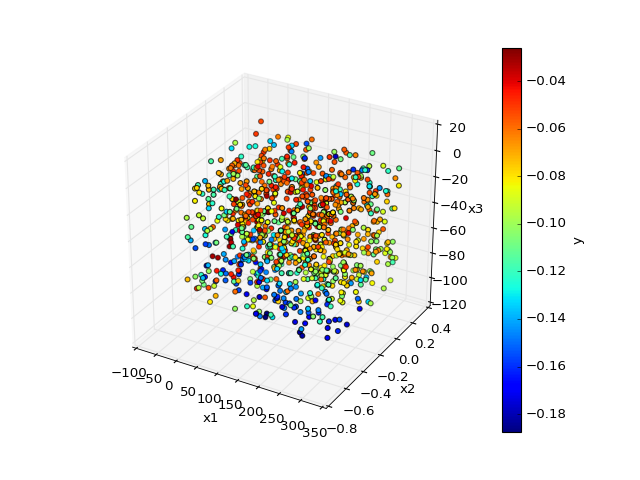

(<matplotlib.figure.Figure at 0x10b1ba710>,
  <matplotlib.axes._subplots.Axes3DSubplot at 0x114717350>])

In [6]:
xCols = [0,2,-1]
yLow = None#-0.05
yHigh = None#0.05
numPoints = 600

#point value
#fig, _ = graph_highD.graph3x1y(s_x, v, xCols=xCols,
#                      sbpltLoc=221, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, c, xCols=xCols, fig=fig,
#                      sbpltLoc=222, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, t, xCols=xCols, fig=fig,
#                      sbpltLoc=223, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, s, xCols=xCols, fig=fig,
#                      sbpltLoc=224, numPoints=numPoints)

#sensor sample
#graph_highD.graph3x1y(s_x, y_smpl, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)
#sensor expecation

print rand_x.shape
print rand_y.shape

#graph_highD.graph3x1y(s_x, y, xCols=xCols,
#                      yLow=yLow, yHigh=yHigh, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

graph_highD.graph3x1y(rand_x, rand_y, xCols=xCols,
                      yLow=yLow, yHigh=yHigh, fig=None,
                      sbpltLoc=111, numPoints=numPoints*2)

#actual sensor
#graph_highD.graph3x1y(s_x, s_t, xCols=xCols,
#                      yLow=yLow, yHigh=yHigh, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

In [7]:
explorerSeries = np.array(main.space.expHQ._explorerSeries)
explorerGradients = np.array(main.space.expHQ._explorerGrads)
explorerVals = np.array(main.space.expHQ._explorerVals)
explorerBest = np.array(main.space.expHQ._explorerBest)

<IPython.core.display.Javascript object>


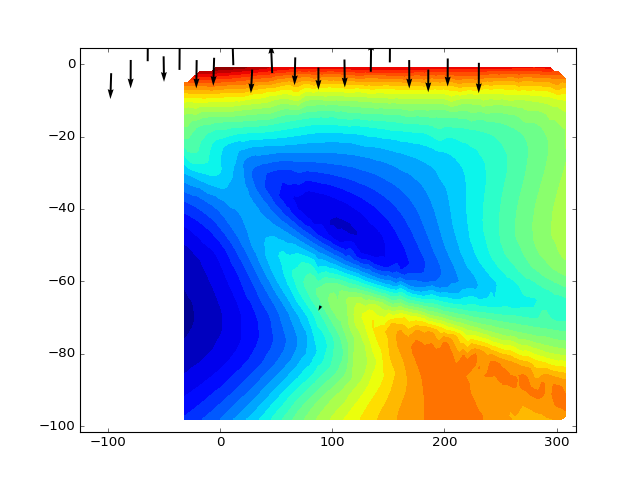

99%

In [8]:
def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    #stolen from http://stackoverflow.com/questions/18764814/make-contour-of-scatter
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)
    Z = mlab.griddata(x, y, z, xi, yi, interp='linear')
    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

#ea is exploration animation
ea_numSkip = 1
ea_viewSection = (.4, .6)
ea_start = int(ea_viewSection[0]*explorerSeries.shape[0])
ea_end = int(ea_viewSection[1]*explorerSeries.shape[0])


ea_mapResolution = 2000 # m
ea_CFindices = np.array([0,-1])  # needs to be 2d for this to work.

ea_fig = plt.figure()

ea_artists = []

ea_EFmask = np.ones(explorerSeries[0,0,:].shape, dtype=bool)  # .shape == (xDim,)
ea_EFmask[ea_CFindices] = 0
ea_full = np.zeros(((ea_mapResolution,) + ea_EFmask.shape), dtype=float)  # .shape == (m, xDim)

ea_conRands = np.random.random_sample(size=(ea_mapResolution, ea_CFindices.size))  #.shape == (m, numCF)
ea_rangeSize = main.space.expHQ._xRange[ea_CFindices]*np.array([[-1,1]])  #.shape == (numCF, 2)
ea_conRands *= np.expand_dims(np.sum(ea_rangeSize, axis=1), 0)  # (m, numCF) * (1, numCF)
ea_conRands += np.expand_dims(main.space.expHQ._xRange[ea_CFindices,0], 0)  # (m, numCF) * (1, numCF)
assert ea_conRands.shape == (ea_mapResolution, ea_CFindices.size)

#For monkey fix below
def ea_setvisible(self,vis):
        for c in self.collections: c.set_visible(vis)
def ea_setanimated(self,anim):
        for c in self.collections: c.set_animated(anim)
####

#TEMP get half explorers for two kinds. dkwig90101kdnfko
#ea_numE = explorerSeries.shape[1]
#ea_half = int(ea_numE/2)
#/TEMP

ea_testHold = None

for i in range(ea_start,ea_end,ea_numSkip):
    ea_completion = ((float(i)/float(explorerSeries.shape[0]))-ea_viewSection[0])/(ea_viewSection[1]-ea_viewSection[0])
    ea_completion = int(100*ea_completion)
    sys.stdout.write("\r%d%%" % ea_completion)
    sys.stdout.flush()
    
    #set the values for all the explorers
    ea_full[:,ea_EFmask] = explorerSeries[i,0,ea_EFmask]  # set environmentals  (m, xDim)[:,numEF] = (numEF,)
    ea_full[:,ea_CFindices] = ea_conRands  # set controls  (m, xDim)[:,numCF] = (m, numCF)
    
    _, ea_pv, ea_pc, ea_pt, ea_ps, _ = main.space.expHQ.graph_space(ea_full)
    
    
    X, Y, Z = grid(np.copy(ea_full[:,ea_CFindices[0]]), np.copy(ea_full[:,ea_CFindices[1]]), np.squeeze(ea_pv))
    
    #create artists
    ea_contour = plt.contourf(X, Y, Z, 30)
    ea_quiver = plt.quiver(explorerSeries[i,:,ea_CFindices[0]], explorerSeries[i,:,ea_CFindices[1]],
                       explorerGradients[(i-1),:,ea_CFindices[0]], explorerGradients[(i-1),:,ea_CFindices[1]],
                          pivot='tail', width=0.004)
    #TEMP dkwig90101kdnfko
    #ea_quiver = plt.quiver(explorerSeries[i,:ea_half,ea_CFindices[0]], explorerSeries[i,:ea_half,ea_CFindices[1]],
    #           explorerGradients[(i-1),:ea_half,ea_CFindices[0]], explorerGradients[(i-1),:ea_half,ea_CFindices[1]],
    #           pivot='tail', width=0.004)
    #ea_scatter = plt.scatter(explorerSeries[i,ea_half:,ea_CFindices[0]], explorerSeries[i,ea_half:,ea_CFindices[1]],
    #                        marker='*')
    #/TEMP
    
    
    ###Monkey Fix from
    #http://matplotlib.1069221.n5.nabble.com/Matplotlib-1-1-0-animation-vs-contour-plots-td18703.html
    ea_contour.set_visible = types.MethodType(ea_setvisible,ea_contour,None)
    #ea_contour.axes = plt.gca()
    ###End monkey fix
    ###Monkey Fix 2
    #adapted from monkey fix 1
    ea_contour.set_animated = types.MethodType(ea_setanimated,ea_contour,None)
    ea_contour.axes = plt.gca()
    ###
    
    ea_artists.append((ea_contour,ea_quiver))

ea_ani = animation.ArtistAnimation(ea_fig, ea_artists, interval=50, repeat_delay=2000, blit=True)
#ea_ani.save('data/ea_test.mp4', metadata={'artist':'Andy'})

<IPython.core.display.Javascript object>


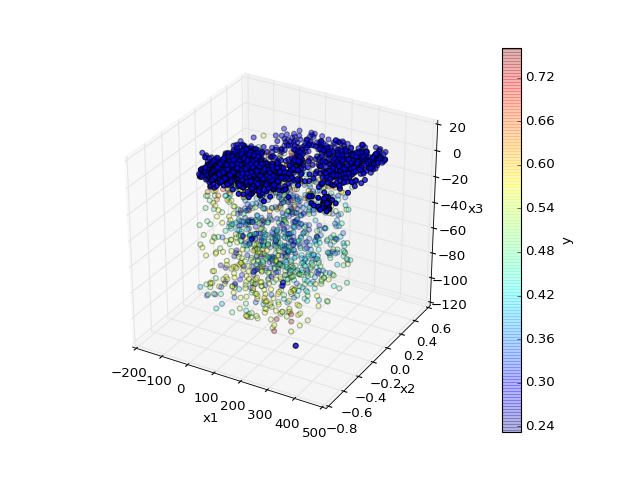

In [9]:
#fig, figStuff = graph_highD.graph3x1y(rand_x, rand_y, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

#pv
fig, figStuff = graph_highD.graph3x1y(rand_x, rand_pv_v, xCols=xCols, fig=None,
                      sbpltLoc=111, numPoints=numPoints*2, alpha=0.3)

figStuff[1].scatter(
                    xs = explorerBest[:,xCols[0]],
                    ys = explorerBest[:,xCols[1]],
                    zs = explorerBest[:,xCols[2]],
                    )
explorerID = 5
#figStuff[1].plot(
#                    xs = explorerSeries[:,explorerID,xCols[0]],
#                    ys = explorerSeries[:,explorerID,xCols[1]],
#                    zs = explorerSeries[:,explorerID,xCols[2]])

#------
#fig, figStuff = graph_highD.graph3x1y(rand_x, rand_pv_c, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2, alpha=0.3)

(1893, 20, 4)
(1893, 20, 4)
(1893, 20)
(1893,)
(1893,)


<IPython.core.display.Javascript object>


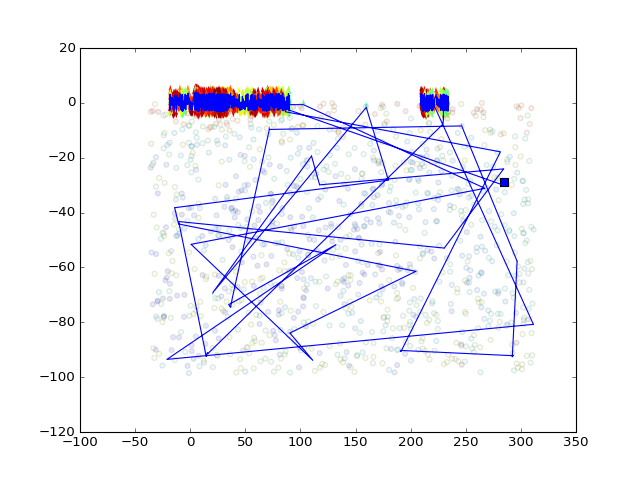

In [10]:
#explorerSeries.shape = (s, e, x)
#explorerVals.shape = (s, e)
print explorerGradients.shape
print explorerSeries.shape
print explorerVals.shape

print explorerSeries[:,explorerID,0].shape
print explorerVals[:,explorerID].shape

plt.figure()
plt.quiver(explorerSeries[:,explorerID,0], explorerSeries[:,explorerID,-1],
           explorerGradients[:,explorerID,0], explorerGradients[:,explorerID,-1],
           explorerVals[:,explorerID]
          )
plt.plot(explorerSeries[:,explorerID,0], explorerSeries[:,explorerID,-1])
#start point
plt.scatter(explorerSeries[0,explorerID,0], explorerSeries[0,explorerID,-1], marker='s', s=50)


#flattened point value graph over the features
plt.scatter(rand_x[:,0], rand_x[:,-1], c=rand_pv_v, alpha=0.1)

In [11]:
print pv_tests[3]

[[-0.0588407   0.43477255  0.46333027 -0.31303659  0.52857476  0.21753599
  -0.31297883  0.22702657  0.18695244 -0.51010633 -0.63394576 -0.29992861
  -0.18883221 -0.10930493 -0.00635129 -0.06360687  0.36298808 -0.48606294
   0.31583777  0.75993955 -0.11336525 -0.0499018   0.31791323 -0.71481025
  -0.75800312]
 [ 0.6511181  -0.26814169  0.25858638 -0.1127968   0.43386817 -0.34070882
  -0.61422288 -0.06687763 -0.06077064 -0.15222013 -0.95924026  0.13874967
  -0.04929237 -0.35325679 -0.31150937  0.40432629  0.47707143  0.43466911
  -0.97119975  0.22652657 -0.39747268 -0.18053138 -0.46497107  0.58230942
  -0.49800867]
 [ 0.01824307  0.00693863 -0.15326332  0.38449156  0.33985329  0.37644944
  -0.49743646  0.98157179  0.26893884  0.77226096 -0.64058542  0.50716472
  -0.41356295 -0.06594325  0.28277466  0.4670043   0.6574313   0.11248792
   0.36835349  0.3220368  -0.17261019  0.61062813  0.68977898  0.01598665
   0.87608242]
 [ 0.62695009  0.49346402  0.43208367  0.25046459 -0.1104568   0.27

In [12]:
print y

[[-0.07451701]
 [-0.07449989]
 [-0.07450345]
 ..., 
 [-0.05951161]
 [-0.05915756]
 [-0.05868689]]


In [13]:
evalStr = [
    'calc_agg_grad_w1',
    'calc_agg_grad_b1',
    'calc_agg_grad_w2',
    'calc_agg_grad_b2',
    'calc_agg_grad_w3',
    'calc_agg_grad_b3',

    'v',
    'm',
    'u',
    
    'w1',
    'w2',
    'w3',
    'b1',
    'b2',
    'b3'
    ]
d = main.space.expModel.get_evals(evalStr)

print d['w1']
print d['b2']

[[ 0.12022106 -0.51944041  0.03872205  0.67679822 -0.34496957  0.33542231
   0.4910188  -0.63106316  0.3280203  -0.43767437 -0.01534957  0.04254021
   0.14175302 -0.22306541  0.45852265 -0.72357547  0.22240467 -0.3200345
  -0.05553206 -0.22007415  0.80850327  0.84808129 -0.05229899 -0.50477761
   0.19422401]
 [ 0.32135382 -0.71519154 -0.78737098 -0.56463057  0.48744699 -0.1214204
   0.48159009  0.56144553  0.75870693 -0.14739633  0.56290948 -0.0090788
  -0.60748863  0.52467334  0.26770252  0.52650565 -0.02757555  0.81928611
   0.03167374  0.37511227  0.36153471 -0.099645   -0.345909   -0.28425997
  -0.91770196]
 [ 0.28527567  0.83308542 -0.07715364 -0.98217863  0.04720336  0.15368585
   0.00993157  0.11166985 -0.33022258 -0.31575799  0.15500106 -0.13569139
  -0.31292334 -0.42090338 -0.01943928 -0.5113368  -0.55364645 -0.40156987
  -0.15965573 -0.35245514 -0.26841828 -0.26394221 -0.24936402  0.42092189
  -0.11416113]
 [-0.7535724  -0.05443321  0.79529738 -0.31837213 -0.54809779  0.24266

In [14]:
np.ones((5,3,2)).shape[1:]

(3, 2)

In [15]:
x = main.space.expHQ.test_actuals['isolationGrad']
print x

[[ 0.0831672   0.          0.         -0.00735512]
 [ 0.36450815  0.          0.         -0.02696458]
 [-0.06297918  0.          0.         -0.0088832 ]
 [ 0.48215628  0.          0.          0.03205174]
 [-0.11059371  0.          0.         -0.04496467]
 [ 0.19393507  0.          0.          0.00947469]
 [-0.23271477  0.          0.         -0.02172429]
 [ 0.23304167  0.          0.          0.01011955]
 [-0.35970098  0.          0.          0.00442847]
 [ 0.16277808  0.          0.          0.03560586]
 [-0.07064492  0.          0.         -0.01069326]
 [-0.04530929  0.          0.          0.00182104]
 [-0.17872368  0.          0.          0.00900357]
 [-0.07682317  0.          0.         -0.00487948]
 [-0.05997174  0.          0.         -0.03159978]
 [ 0.0519889   0.          0.          0.0017401 ]
 [-0.16509907  0.          0.          0.01494518]
 [-0.1389288   0.          0.          0.05539366]
 [ 0.00063245  0.          0.          0.05706534]
 [-0.07071839  0.          0.  